In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

In [2]:
sys.path.append('../common')
import collect_dem

In [13]:
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('text', usetex=True)
font_size = 
rc('font', size=font_size)
rc('axes.labelsize', size=font_size)
rc('axes', titlesize=font_size)

In [14]:
fault_data = open('landers_fault', 'r').read()

rows = fault_data.split('\n')
raw_fault_segs = []
for r in rows:
    if len(r) == 0:
        continue
    cols = r.split(' ')
    segment_name = ''
    for c_idx in range(len(cols)):
        if cols[c_idx][0].isalpha():
            segment_name += cols[c_idx] + ' '
        else:
            break
    lat = float(cols[c_idx])
    lon = float(cols[c_idx + 1])
    length_km = float(cols[c_idx + 2])
    azimuth_deg_ccw_from_east = float(cols[c_idx + 3])
    slip_cm = float(cols[c_idx + 4])
    raw_fault_segs.append((segment_name, lat, lon, length_km, azimuth_deg_ccw_from_east, slip_cm))

In [15]:
from pyproj import Geod
g = Geod(ellps = 'WGS84')
fault_edges = []
for s in raw_fault_segs:
    center_lat = s[1]
    center_lon = s[2]
    length_m = 0.5 * s[3] * 1000
    az_from_n = -90 - s[4]
    start_lon, start_lat, back_az = g.fwd(center_lon, center_lat, az_from_n, -length_m)
    end_lon, end_lat, back_az = g.fwd(center_lon, center_lat, az_from_n, length_m)
    fault_edges.append(np.array([[start_lat, start_lon], [end_lat, end_lon]]))
fault_edges = np.array(fault_edges)

In [16]:
pts = np.fliplr(fault_edges.reshape((-1, 2)))
els = np.arange(pts.shape[0]).reshape((-1, 2))
m = (pts, els)

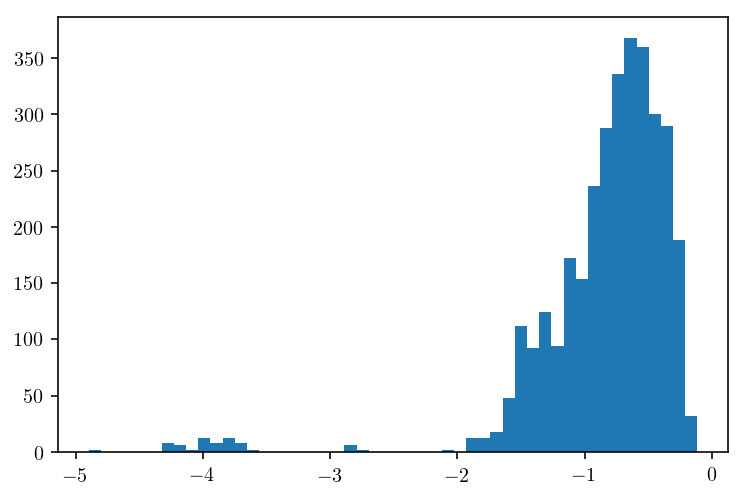

In [18]:
import scipy.spatial.distance
def plot_distance_distribution(m):
    dist = scipy.spatial.distance.cdist(m[0], m[0])
    %matplotlib inline
    #plt.figure(figsize = (10,10))
    plt.hist(np.log10(np.abs(dist[dist > 0])), bins = 50)
    plt.show()
plot_distance_distribution(m)

number of remaining pts: 31


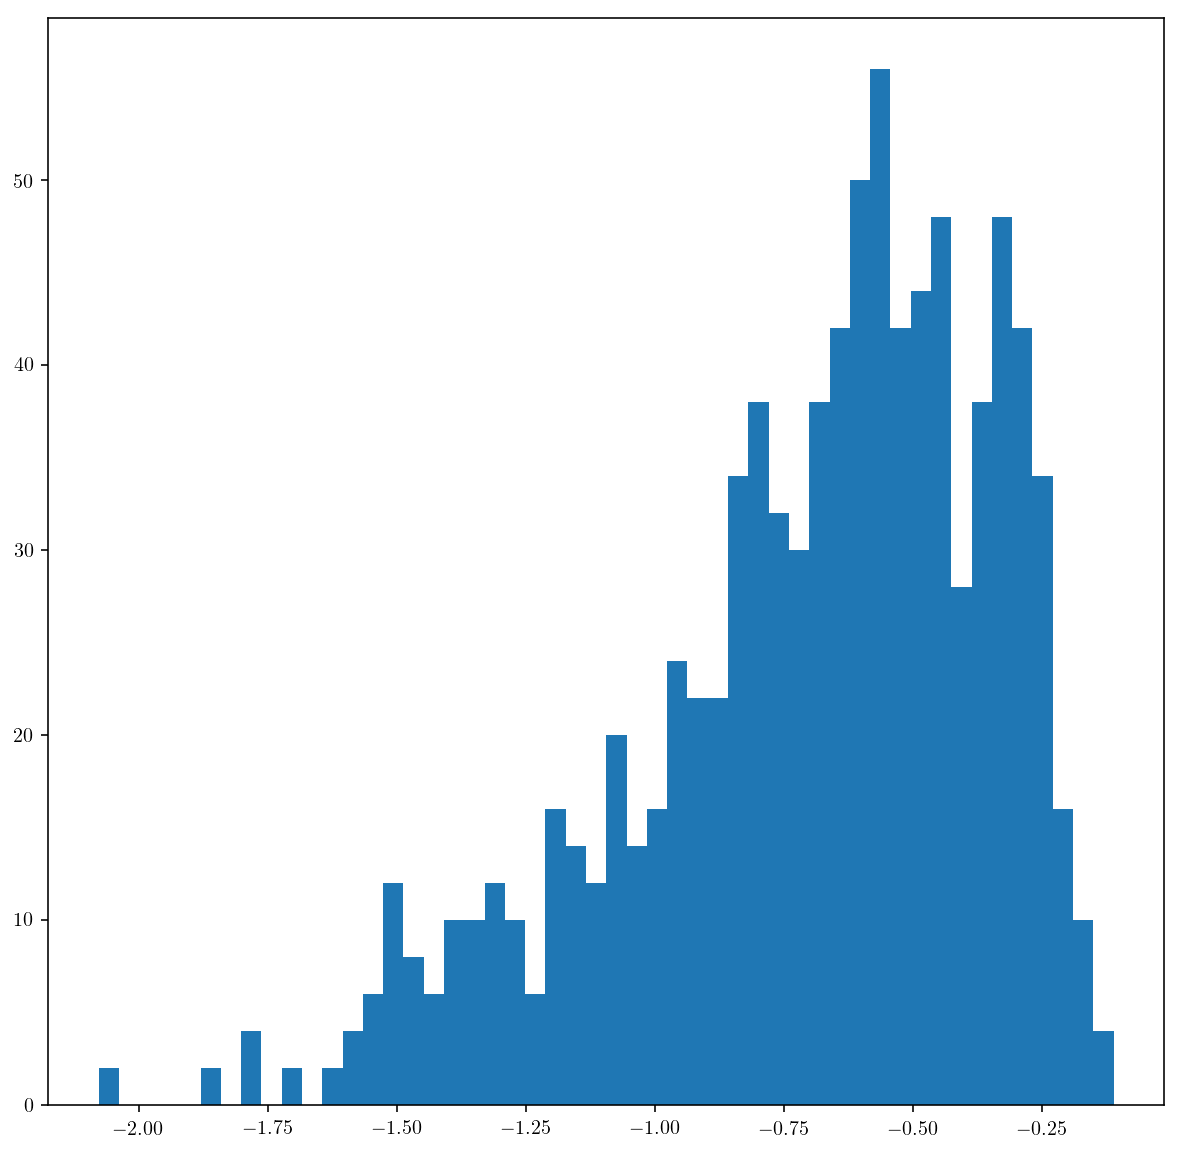

In [11]:
from tectosaur.mesh.modify import remove_duplicate_pts
m_combined = remove_duplicate_pts(remove_duplicate_pts((pts, els), 6e-3), 5e-3)
print('number of remaining pts: ' + str(m_combined[0].shape[0]))
plot_distance_distribution(m_combined)

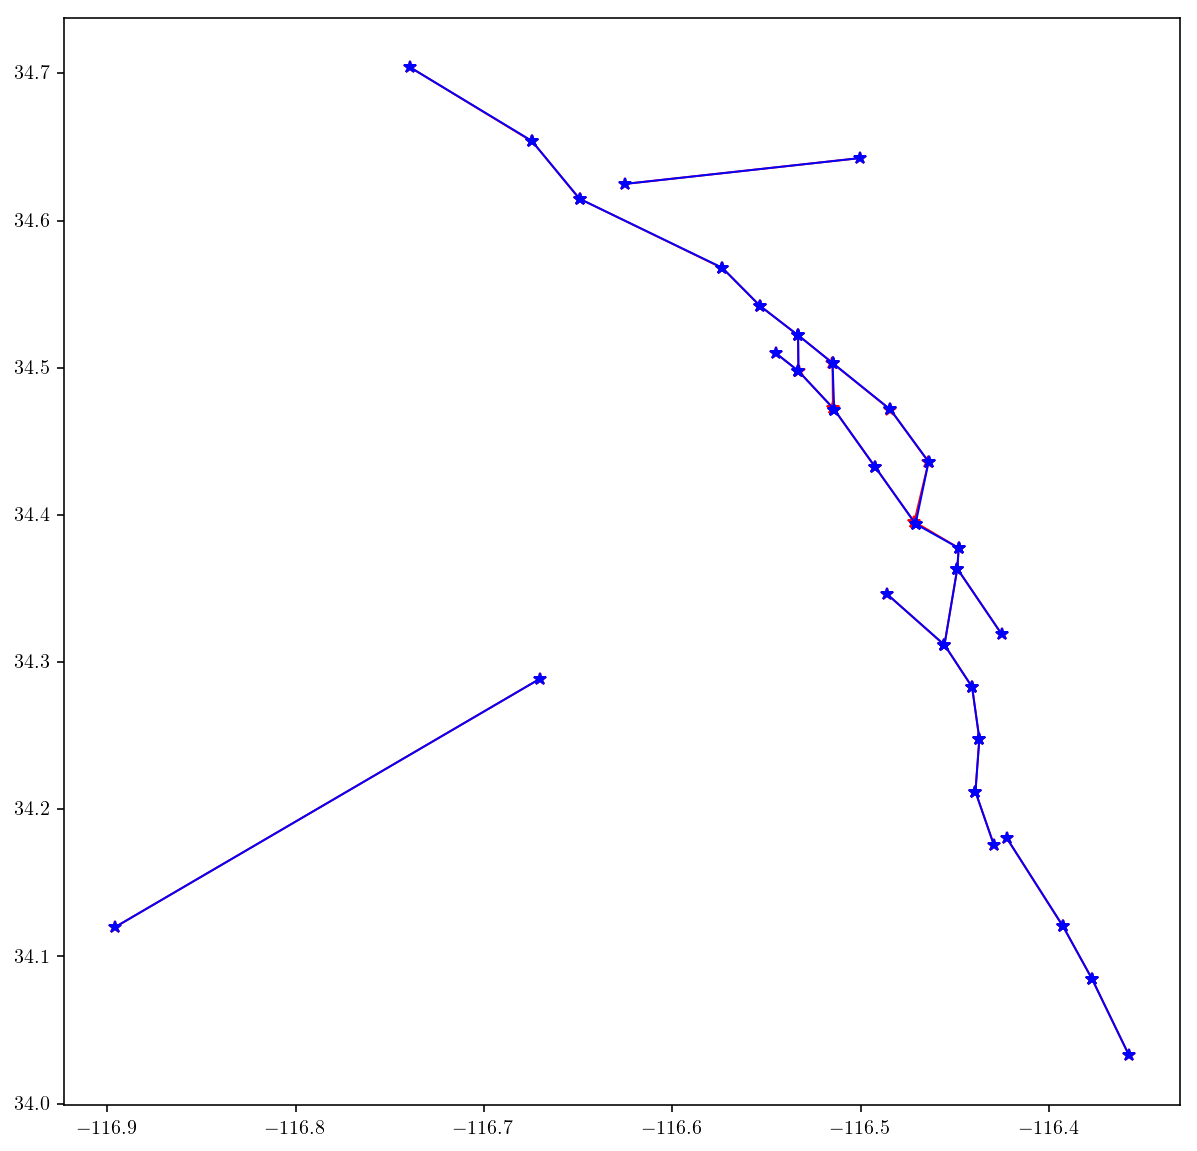

In [14]:
%matplotlib inline
plt.figure(figsize = (10, 10))
for plot_mesh, color in [(m, 'r'), (m_combined, 'b')]:
    for i in range(plot_mesh[1].shape[0]):
        el_pts = plot_mesh[0][plot_mesh[1][i,:]]
        plt.plot(el_pts[:,0], el_pts[:,1], color + '-*', linewidth = 1.0)
plt.show()

In [15]:
surf_center = np.mean(m_combined[0], axis = 0)
fault_L = np.max(np.sqrt(np.sum((m_combined[0] - surf_center) ** 2, axis = 1)))
mesh_size = fault_L / 10
surf_center, fault_L

(array([-116.51585025,   34.3887789 ]), 0.46580676933784021)

In [16]:
import pygmsh
geom = pygmsh.built_in.Geometry()

w = fault_L * 4
surf_corners = np.array([
    [surf_center[0] - w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] + w, 0],
    [surf_center[0] - w, surf_center[1] + w, 0],
])
surf = geom.add_polygon(surf_corners, mesh_size)

gmsh_pts = dict()
for edge in m_combined[1]:
    for j in range(2):
        if edge[j] not in gmsh_pts:
            pt = m_combined[0][edge[j]].tolist()
            pt.append(0)
            gmsh_pts[edge[j]] = geom.add_point(pt, mesh_size)
    line = geom.add_line(gmsh_pts[edge[0]], gmsh_pts[edge[1]])
    intersection_code = 'Line{{{}}} In Surface{{{}}};'.format(
        line.id, surf.surface.id
    )
    geom.add_raw_code(intersection_code)

In [17]:
points, cells, pt_data, cell_data, field_data = pygmsh.generate_mesh(
    geom, dim = 2, num_lloyd_steps = 0, num_quad_lloyd_steps = 0
)
surf_m = (points, cells['triangle'])

Info    : Running 'gmsh -2 -bin /tmp/tmp53n3qij2.geo -o /tmp/tmpouxtoh3s.msh' [Gmsh 3.0.5, 1 node, max. 1 thread]
Info    : Started on Wed Oct 25 11:07:09 2017
Info    : Reading '/tmp/tmp53n3qij2.geo'...
Info    : Done reading '/tmp/tmp53n3qij2.geo'
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve

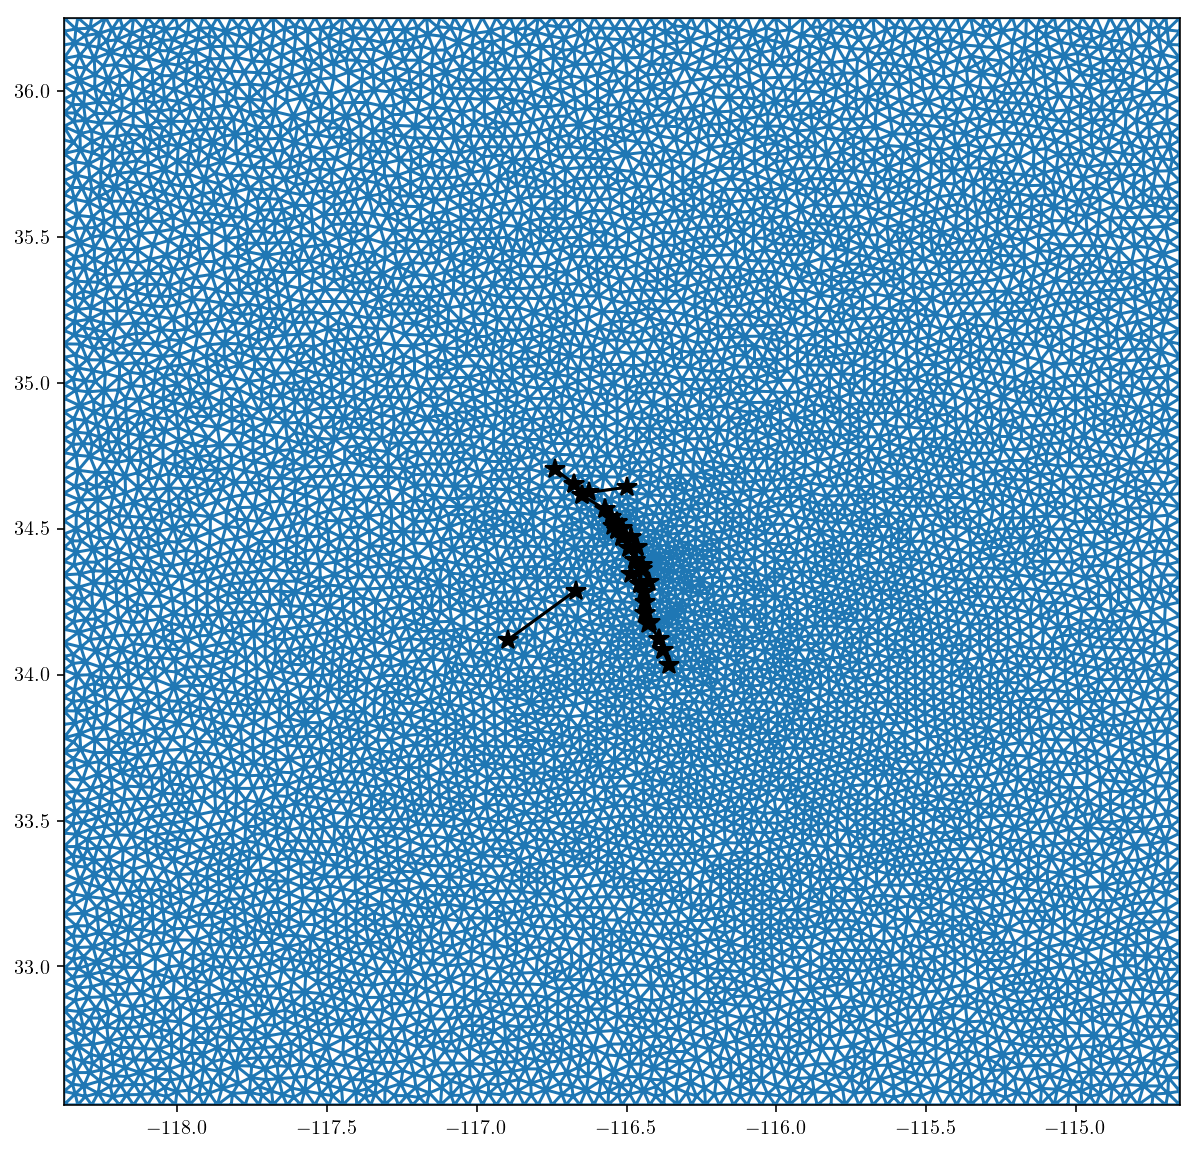

In [21]:
plt.figure(figsize = (10,10))
plt.triplot(points[:,0], points[:,1], cells['triangle'])
for edge in m_combined[1]:
    pts = m_combined[0][edge]
    plt.plot(pts[:,0], pts[:,1], 'k-*', markersize = 10)
vW = 4 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.show()

In [58]:
bounds = collect_dem.get_dem_bounds(points)
bounds

(32.152906409620236,
 -118.75172274590753,
 36.624651395263506,
 -114.27997776026427)

In [61]:
zoom = 5
n_dem_interp_pts = 300
proj = 'utm11S'

32.1529064096 -118.751722746 36.6246513953 -114.27997776
5 5 12


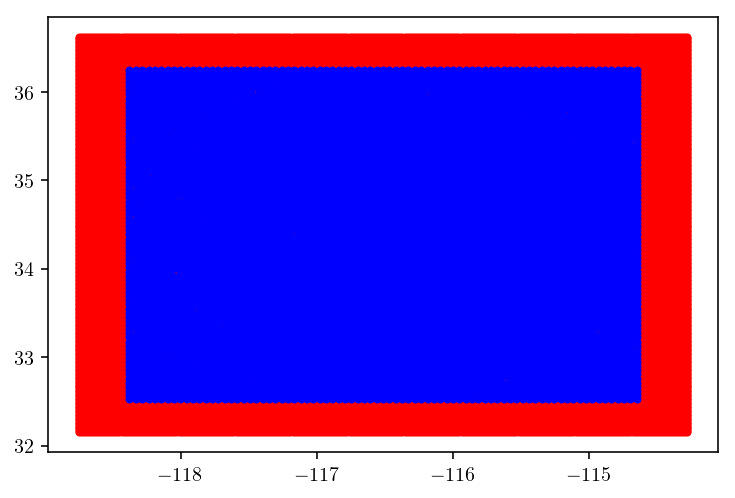

In [64]:
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)
plt.plot(LON, LAT, 'r.')
plt.plot(points[:,0], points[:,1], 'b.')
plt.show()

In [68]:
fault_pt_elevations = scipy.interpolate.griddata(
    (LON, LAT), DEM,
    (m_combined[0][:,0], m_combined[0][:,1])
)
vertical_diff = fault_pt_elevations - m_combined[0][:,2]
below_surf = np.abs(vertical_diff) >= 800
above_surf = np.logical_not(below_surf)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [66]:
surf_m[0][:,2] = scipy.interpolate.griddata(
    (LON, LAT), DEM,
    (surf_m[0][:,0], surf_m[0][:,1])
)
m_combined[0][refined_above_surf,2] = scipy.interpolate.griddata(
    (LON, LAT), DEM,
    (m_combined[0][refined_above_surf,0], m_combined[0][refined_above_surf,1])
)

NameError: name 'combined_m' is not defined